In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=5b3ee2b167d54861688d396573378cbe771e7a85a9dcff43568671487fcdd77e
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric import nn as gnn

from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
splits = ["train", "valid", "test"]

In [4]:
layout_nlp_default = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/nlp/default'
layout_nlp_random = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/nlp/random'
layout_xla_default = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/xla/default'
layout_xla_random = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/layout/xla/random'

tile_xla = '/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla'

In [5]:
def load_data_to_df(directory, split):

    path = os.path.join(directory, split)
    print(path)
    files = os.listdir(path)
    
    data_list = []
    for file in tqdm(files):
        file_path = os.path.join(path, file)
        model_graph = dict(np.load(file_path))
        model_graph["file"] = file
        data_list.append(model_graph)
        
    return pd.DataFrame(data_list)

In [6]:
df_train = load_data_to_df(tile_xla, "train")
df_valid = load_data_to_df(tile_xla, "valid")
df_test = load_data_to_df(tile_xla, "test")

/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/train


100%|██████████| 5709/5709 [00:37<00:00, 151.07it/s]


/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/valid


100%|██████████| 676/676 [00:04<00:00, 162.60it/s]


/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla/test


100%|██████████| 844/844 [00:04<00:00, 170.23it/s]


In [7]:
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = gnn.GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = gnn.GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [8]:
class TileModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        op_embedding_dim = 8
        self.opcode_embedding = nn.Embedding(120, op_embedding_dim)
        
        node_feature_dim = 140
        
        hidden_channels = 8
        heads = 8
        conv_out_dim = 48
        
        self.conv = GAT(op_embedding_dim + node_feature_dim, hidden_channels, conv_out_dim, heads)
        # self.conv = gnn.GCNConv(op_embedding_dim + node_feature_dim, conv_out_dim)
        
        config_dim = 24
        self.fwd = nn.Sequential(
            nn.Linear(conv_out_dim + config_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, 1)
        )
        
        
    def forward(self, node_feat, node_opcode, edge_index, config_feat):
        """
            Shapes:
                node_feat    - (n, 140)
                node_opcode  - (n, )
                edge_index   - (m, 2)
                config_feat  - (c, 24)
            
            Approach:
                1. Opcode embeddings
                2. Concatenate embeddings to node feature-vector
                3. Convolutional layer for node embeddings
                4. Pooling for graph embedding
                5. Concatenate configuration feature-vector to graph embedding
                6. Forward layer
                7. Flatten
            
            Approach is inline with the paper Phitchaya Mangpo Phothilimthana et. al (2023) 
        """
        node_opcode_embedding = self.opcode_embedding(node_opcode) # (n, 8)
        
        x = torch.concat([node_feat, node_opcode_embedding], dim = 1) # (n, 148)
        
        x = self.conv(x, edge_index) # (n, 48)
                
        x = torch.mean(x, 0) # (48, )    
            
        x = x.repeat(len(config_feat), 1) # (c, 48)
        
        x = torch.concat([x, config_feat], dim = 1) # (c, 72)
        
        x = self.fwd(x) # (c, 1)
        
        return torch.flatten(x) # (c, )
        

In [9]:
class TileDataset(Dataset):
    
    def __init__(self, tiles):
        self.tiles = tiles
    
    def __len__(self):
        return len(self.tiles)
    
    def __getitem__(self, idx):
        
        file = self.tiles.iloc[idx]['file']
        node_feat = torch.from_numpy(self.tiles.iloc[idx]['node_feat'])
        node_opcode = torch.from_numpy(self.tiles.iloc[idx]['node_opcode']).type(torch.int64)
        edge_index = torch.from_numpy(self.tiles.iloc[idx]['edge_index']).permute(1, 0)
        config_feat = torch.from_numpy(self.tiles.iloc[idx]['config_feat'])
        config_runtime = torch.from_numpy(self.tiles.iloc[idx]['config_runtime'])
        config_runtime_normalizers = torch.from_numpy(self.tiles.iloc[idx]['config_runtime_normalizers'])
        
        return {
            "file": file,
            "node_feat": node_feat,
            "node_opcode": node_opcode,
            "edge_index": edge_index,
            "config_feat": config_feat,
            "y": config_runtime / config_runtime_normalizers
        }
    
    def __iter__(self):
        self.i = 0
        return self
    
    def __next__(self):
        if self.i < len(self.tiles):
            item = self[self.i]
            self.i += 1
            return item
        else:
            raise StopIteration
    
train_dataset = TileDataset(df_train)
valid_dataset = TileDataset(df_valid)
test_dataset = TileDataset(df_test)

In [10]:
model = TileModel()

data = train_dataset[0]

model(data['node_feat'], data['node_opcode'], data['edge_index'], data['config_feat'])

tensor([5107.0596, 5110.9238, 5110.7847,  ..., 5103.2891, 5107.1128,
        5106.5981], grad_fn=<ReshapeAliasBackward0>)

In [11]:
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 19745


## Training

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TileModel().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 10

train_losses = np.empty((0,))
valid_losses = np.empty((0,))
    


def train():
    model.train()
    
    epoch_train_losses = np.empty((0,))
    for tile in train_dataset:
        
        node_feat, node_opcode, edge_index, config_feat = tile["node_feat"].to(device), tile["node_opcode"].to(device), tile["edge_index"].to(device), tile["config_feat"].to(device)
        
        optimizer.zero_grad()
        pred = model(node_feat, node_opcode, edge_index, config_feat).to("cpu")
        loss = loss_fn(pred, tile["y"])
                
        loss.backward()
        optimizer.step()
        
        epoch_train_losses = np.append(epoch_train_losses, loss.item())
    return np.mean(epoch_train_losses)

def test():
    model.eval()
    
    epoch_valid_losses = np.empty((0,))
    
    with torch.no_grad():
        for tile in valid_dataset:
                
            node_feat, node_opcode, edge_index, config_feat = tile["node_feat"].to(device), tile["node_opcode"].to(device), tile["edge_index"].to(device), tile["config_feat"].to(device)
    
            pred = model(node_feat, node_opcode, edge_index, config_feat).to("cpu")
            loss = loss_fn(pred, tile["y"])
            
            epoch_valid_losses = np.append(epoch_valid_losses, loss.item())
    return np.mean(epoch_valid_losses)


for i in range(1, epochs + 1):
    
    train_loss = train()
    valid_loss = test()
    
    train_losses = np.append(train_losses, train_loss)
    valid_losses = np.append(valid_losses, valid_loss) 
    print(f"Epoch: {i}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}")


Epoch: 1, Train Loss: 165791593421295.4, Valid Loss: 73.56312710293652
Epoch: 2, Train Loss: 289692578138648.0, Valid Loss: 46.390057289036065
Epoch: 3, Train Loss: 1253125703.5839903, Valid Loss: 46.51539447251156
Epoch: 4, Train Loss: 30242428.15012961, Valid Loss: 47.01722163244112
Epoch: 5, Train Loss: 757659465.5998391, Valid Loss: 42.6974915105563
Epoch: 6, Train Loss: 54.80074416299984, Valid Loss: 30.278347714236503
Epoch: 7, Train Loss: 2036.9717171739667, Valid Loss: 30.107208373631245
Epoch: 8, Train Loss: 150.97492872900773, Valid Loss: 30.12721615042207
Epoch: 9, Train Loss: 40.165743556169225, Valid Loss: 30.163752365747147
Epoch: 10, Train Loss: 36.870609023469115, Valid Loss: 30.115585479157915


In [13]:
# Store model
torch.save(model.state_dict(), "tile_model.pt")

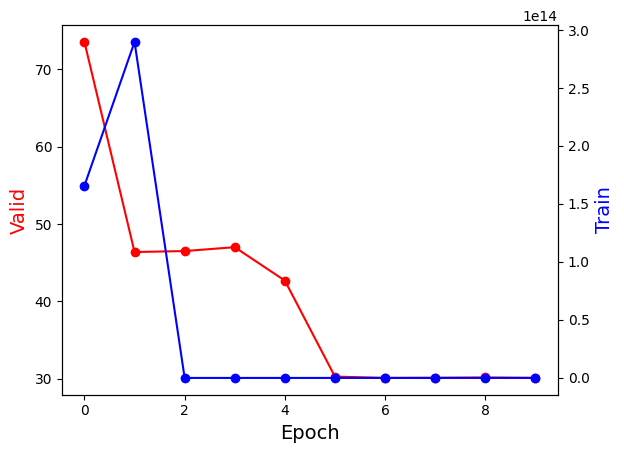

In [14]:
# Plot losses
all_epochs = list(range(epochs))

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(all_epochs,
        valid_losses,
        color="red", 
        marker="o")
# set x-axis label
ax.set_xlabel("Epoch", fontsize = 14)
# set y-axis label
ax.set_ylabel("Valid",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(all_epochs, train_losses,color="blue",marker="o")
ax2.set_ylabel("Train",color="blue",fontsize=14)
plt.show()


In [15]:
def predict(tile, model):
    model = model.to(device)
    node_feat = tile["node_feat"].to(device)
    node_opcode = tile["node_opcode"].to(device)
    edge_index = tile["edge_index"].to(device)
    config_feat = tile["config_feat"].to(device)
    
    out = model(node_feat, node_opcode, edge_index, config_feat).to("cpu")
    return torch.sort(out).indices[:5]
    

In [16]:
def get_predictions_per_file(model, dataset):
    
    if isinstance(model, str):
        state_dict = torch.load(model)
        model = TileModel()
        model.load_state_dict(state_dict)
    
    model.eval()
    prediction_for_file = {}
    
    with torch.no_grad():
        for tile in dataset:
            prediction_for_file[tile["file"]] = predict(tile, model)

    return prediction_for_file

In [17]:
def evaluate_model(model):
    
    # Make predictions
    predictions = list(get_predictions_per_file(model, valid_dataset).values())

    # Calculate score
    scores = np.empty((0,))

    for i, tile in tqdm(enumerate(valid_dataset), total=len(valid_dataset)):
        best_prediction = min([valid_dataset[i]["y"][pred_ind] for pred_ind in predictions[i][:5]])
        best_total = min(valid_dataset[i]["y"])
        scores = np.append(scores, 2.0 - best_prediction / best_total)

    avg_score = np.mean(scores)
    print("Score:", avg_score)
    return avg_score
    

In [18]:
evaluate_model(model)

100%|██████████| 676/676 [00:06<00:00, 99.44it/s] 

Score: 0.4396090775551881


0.4396090775551881

In [19]:
def create_submission():
    
    submission = pd.read_csv("/kaggle/input/predict-ai-model-runtime/sample_submission.csv")
    
    predictions = get_predictions_per_file("tile_model.pt", test_dataset)
    
    for model_name in predictions.keys():
        model_id = 'tile:xla:' + model_name[:-4]
        submission.loc[submission["ID"] == model_id, "TopConfigs"] = ";".join([str(pred) for pred in predictions[model_name].tolist()])
    
    submission.to_csv("submission.csv", index=False)
        
create_submission()